In [7]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches


In [8]:
# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Cargar el dataset (Ajusta el nombre del archivo si es necesario)
df = pd.read_csv('Dataset_Loja_Preprocesado.csv') 

# Verificación rápida de las variables listas
print("Variables disponibles:", df.columns)
print(df[['VALOR_RECAUDADO', 'TIPO_CONTRIBUYENTE', 'CLUSTER_GEO']].head())

Variables disponibles: Index(['ANIO', 'DIA_MES', 'NOMBRE_MES', 'GRUPO_IMPUESTO', 'SUBGRUPO_IMPUESTO',
       'IMPUESTO', 'GRAN_CONTRIBUYENTE', 'CODIGO_OPERA_FAMILIA',
       'DESCRIPCION_ACT_ECONOMICA', 'TIPO_CONTRIBUYENTE', 'PROVINCIA',
       'CANTON', 'VALOR_RECAUDADO', 'FLAG_GRAN_CONTRIBUYENTE',
       'COD_CONTRIBUYENTE', 'FLAG_ES_CERO', 'CLUSTER_GEO'],
      dtype='object')
   VALOR_RECAUDADO  TIPO_CONTRIBUYENTE  CLUSTER_GEO
0         11413.39  PERSONAS NATURALES            0
1           584.47            NO TIENE            1
2            94.22  PERSONAS NATURALES            1
3         56016.13          SOCIEDADES            1
4             0.00  PERSONAS NATURALES            1


In [9]:
# =============================================================================
# BLOQUE: Preprocesamiento y Codificación
# =============================================================================

# 1. CODIFICACIÓN ORDINAL (El paso que faltaba)
# Transformamos el texto en números jerárquicos
mapeo_tipo = {'NO TIENE': 0, 'PERSONAS NATURALES': 1, 'SOCIEDADES': 2}

# Creamos una copia segura para no dañar el original
X_work = df.copy()

# Aplicamos el mapeo. Si hay algún valor raro, lo llenamos con 0
X_work['TIPO_CODIFICADO'] = X_work['TIPO_CONTRIBUYENTE'].map(mapeo_tipo).fillna(0)

# 2. SELECCIÓN DE VARIABLES (Usamos la numérica, no la de texto)
features = ['VALOR_RECAUDADO', 'TIPO_CODIFICADO', 'CLUSTER_GEO']
X_pre = X_work[features].copy()

# 3. TRANSFORMACIÓN LOGARÍTMICA
# Solo aplicamos logaritmo al dinero, no a la categoría ni a la ubicación
X_pre['VALOR_RECAUDADO'] = np.log1p(X_pre['VALOR_RECAUDADO'])

# 4. ESCALADO ROBUSTO
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_pre)

# 5. CREAR DATAFRAME FINAL LISTO PARA K-MEANS
X_final = pd.DataFrame(X_scaled, columns=features)

print("¡Éxito! Datos transformados a números:")
print(X_final.head())
print("\nVerificación de tipos (todos deben ser float/int):")
print(X_final.dtypes)

¡Éxito! Datos transformados a números:
   VALOR_RECAUDADO  TIPO_CODIFICADO  CLUSTER_GEO
0         1.135188              0.0          0.0
1         0.599707             -1.0          1.0
2         0.272271              0.0          1.0
3         1.421980              1.0          1.0
4        -0.549135              0.0          1.0

Verificación de tipos (todos deben ser float/int):
VALOR_RECAUDADO    float64
TIPO_CODIFICADO    float64
CLUSTER_GEO        float64
dtype: object


Evaluando modelos desde k=5 hasta k=14...
  > k=5: Silueta=0.497
  > k=6: Silueta=0.548
  > k=7: Silueta=0.584
  > k=8: Silueta=0.614
  > k=9: Silueta=0.641
  > k=10: Silueta=0.656
  > k=11: Silueta=0.664
  > k=12: Silueta=0.669
  > k=13: Silueta=0.670
  > k=14: Silueta=0.668


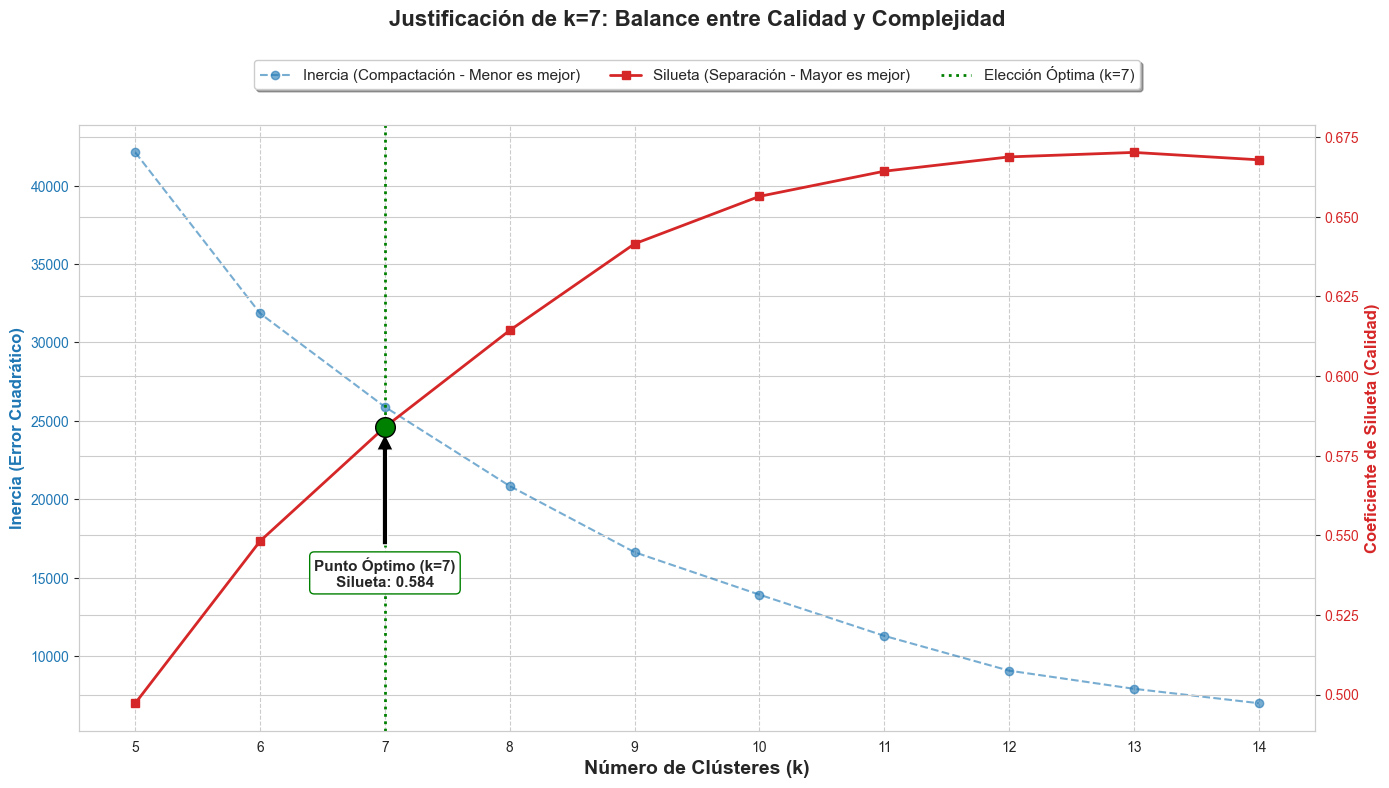

In [10]:
# =============================================================================
# BLOQUE DE JUSTIFICACIÓN (FINAL): EVALUACIÓN DE K CON LEYENDA UNIFICADA
# 1. Configuración del Experimento
k_min, k_max = 5, 15
rango_k = list(range(k_min, k_max))
inertias = []
siluetas = []

# Muestra para velocidad
sample_size = 15000 
X_sample = X_final.sample(n=sample_size, random_state=42) if len(X_final) > sample_size else X_final

print(f"Evaluando modelos desde k={k_min} hasta k={k_max-1}...")

for k in rango_k:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_final)
    inertias.append(kmeans_temp.inertia_)
    
    labels_sample = kmeans_temp.predict(X_sample)
    score = silhouette_score(X_sample, labels_sample)
    siluetas.append(score)
    print(f"  > k={k}: Silueta={score:.3f}")

# 2. GENERACIÓN DE LA GRÁFICA
fig, ax1 = plt.subplots(figsize=(14, 8)) # Un poco más alto para la leyenda arriba

# --- EJE IZQUIERDO (AZUL): INERCIA ---
color_inercia = 'tab:blue'
ax1.set_xlabel('Número de Clústeres (k)', fontsize=14, weight='bold')
ax1.set_ylabel('Inercia (Error Cuadrático)', color=color_inercia, fontsize=12, weight='bold')

# Guardamos la gráfica en una variable 'ln1' para la leyenda luego
ln1 = ax1.plot(rango_k, inertias, 'o--', color=color_inercia, alpha=0.6, 
               label='Inercia (Compactación - Menor es mejor)')

ax1.tick_params(axis='y', labelcolor=color_inercia)
ax1.grid(True, axis='x', linestyle='--')
ax1.set_xticks(rango_k) 

# --- EJE DERECHO (ROJO): SILUETA ---
ax2 = ax1.twinx()
color_silueta = 'tab:red'
ax2.set_ylabel('Coeficiente de Silueta (Calidad)', color=color_silueta, fontsize=12, weight='bold')

# Guardamos la gráfica en 'ln2'
ln2 = ax2.plot(rango_k, siluetas, 's-', color=color_silueta, linewidth=2, 
               label='Silueta (Separación - Mayor es mejor)')

ax2.tick_params(axis='y', labelcolor=color_silueta)

# 3. DESTACAR EL GANADOR (k=7)
if 7 in rango_k:
    idx_7 = rango_k.index(7)
    valor_silueta_7 = siluetas[idx_7]
    
    # Guardamos la linea vertical en 'ln3'
    ln3 = plt.axvline(x=7, color='green', linestyle=':', linewidth=2, label='Elección Óptima (k=7)')
    
    ax2.scatter(7, valor_silueta_7, s=200, c='green', zorder=10, edgecolors='black')
    
    ax2.annotate(f'Punto Óptimo (k=7)\nSilueta: {valor_silueta_7:.3f}', 
                 xy=(7, valor_silueta_7), xytext=(7, valor_silueta_7 - 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=11, weight='bold', ha='center',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green"))

# --- LEYENDA UNIFICADA (EL TRUCO) ---
# Sumamos las listas de objetos gráficos para ponerlos en una sola caja
lineas = ln1 + ln2 + [ln3]
etiquetas = [l.get_label() for l in lineas]

# Ponemos la leyenda ARRIBA del gráfico para que no estorbe
ax1.legend(lineas, etiquetas, loc='upper center', bbox_to_anchor=(0.5, 1.12), 
           ncol=3, fontsize=11, frameon=True, shadow=True, fancybox=True)

plt.title('Justificación de k=7: Balance entre Calidad y Complejidad', fontsize=16, weight='bold', y=1.15)
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# BLOQUE 4 OPTIMIZADO: Entrenamiento Rápido con Muestreo para Métricas
# =============================================================================

# CAMBIO CLAVE: Tus datos piden 6 segmentos
k_optimo = 7

print(f"1. Entrenando modelo K-Means con k={k_optimo} (Esto es rápido)...")

# Entrenamos el modelo con TODOS los datos (K-Means es eficiente aquí)
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_final)

# Asignamos los clústeres al dataframe original
df['CLUSTER_KMEANS'] = clusters
print("   -> Entrenamiento completado.")

# 2. CÁLCULO DE SILUETA (OPTIMIZADO)
# En lugar de usar los 167k datos (que tarda horas), usamos una muestra de 15k
print("2. Calculando Silueta sobre una muestra de 15,000 puntos...")

# Tamaño de muestra seguro para procesadores normales
sample_size = 15000 

if len(X_final) > sample_size:
    X_sample = X_final.sample(n=sample_size, random_state=42)
    labels_sample = kmeans_final.predict(X_sample)
    score_final = silhouette_score(X_sample, labels_sample)
else:
    # Si tienes pocos datos, úsalos todos
    score_final = silhouette_score(X_final, clusters)

print(f"--- RESULTADOS ---")
print(f"Coeficiente de Silueta (Estimado): {score_final:.3f}")

if score_final > 0.5:
    print("ESTADO: EXCELENTE. Los grupos están bien definidos.")
elif score_final > 0.25:
    print("ESTADO: ACEPTABLE. Hay estructura, aunque con solapamiento.")
else:
    print("ESTADO: DÉBIL. Los datos están muy mezclados.")

1. Entrenando modelo K-Means con k=7 (Esto es rápido)...
   -> Entrenamiento completado.
2. Calculando Silueta sobre una muestra de 15,000 puntos...
--- RESULTADOS ---
Coeficiente de Silueta (Estimado): 0.584
ESTADO: EXCELENTE. Los grupos están bien definidos.


Generando modelo final con k=7...


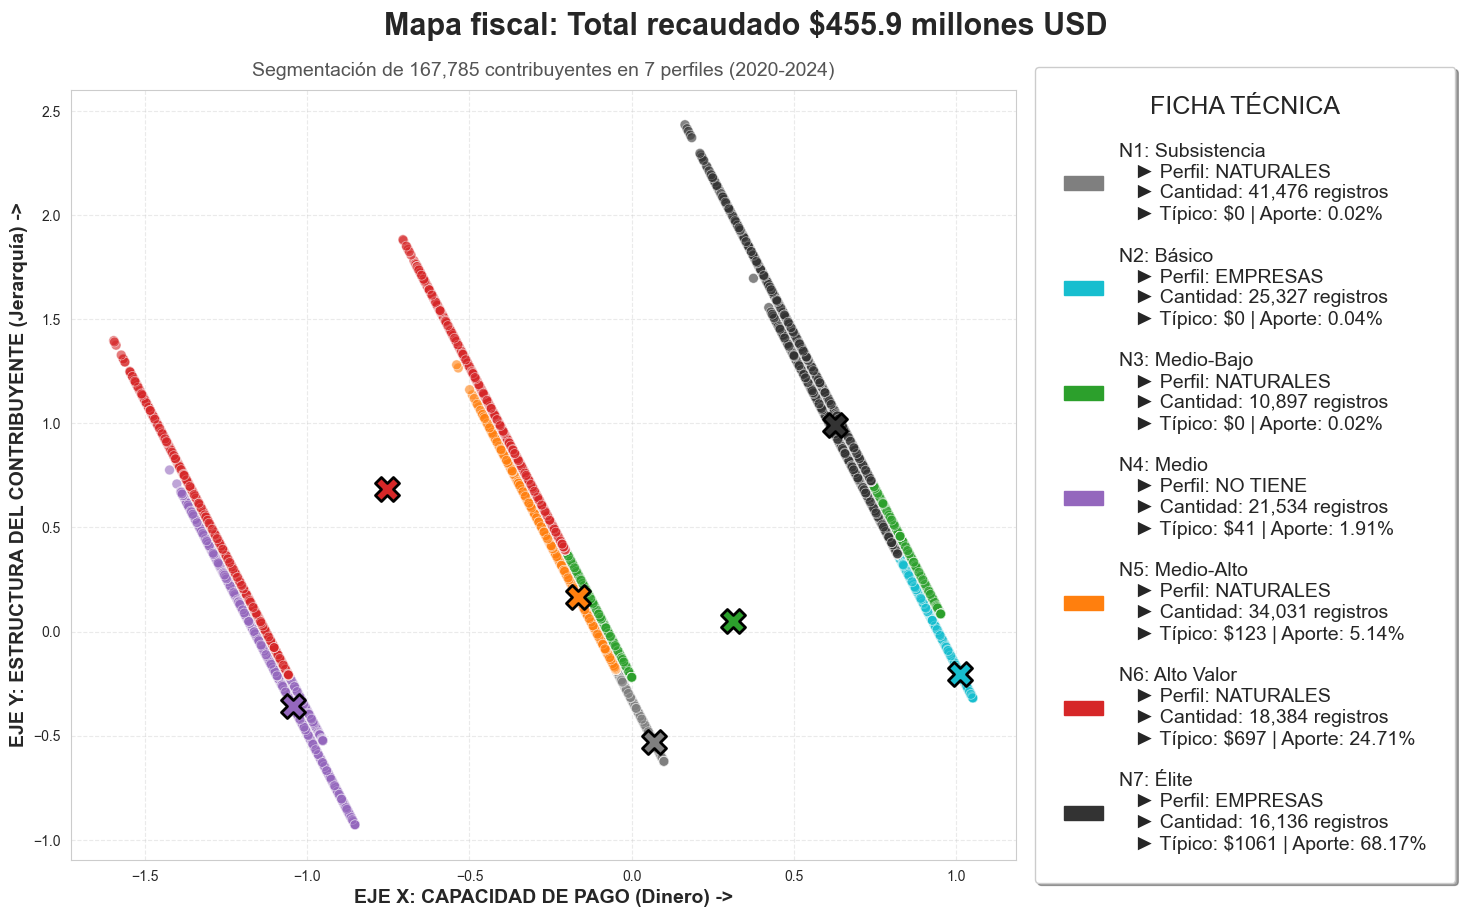

--- RESUMEN EJECUTIVO DEL MODELO ---


,Nombre_Grupo,Cantidad,Tipo_Moda,Mediana,Total_Dinero,Share_Pct
3,N1: Subsistencia,41476,PERSONAS NATURALES,0.00,8.515502e+04,0.02
4,N2: Básico,25327,SOCIEDADES,0.00,1.618124e+05,0.04
6,N3: Medio-Bajo,10897,PERSONAS NATURALES,0.00,7.788160e+04,0.02
2,N4: Medio,21534,NO TIENE,41.27,8.701633e+06,1.91
0,N5: Medio-Alto,34031,PERSONAS NATURALES,122.63,2.341514e+07,5.14
1,N6: Alto Valor,18384,PERSONAS NATURALES,697.35,1.126497e+08,24.71
5,N7: Élite,16136,SOCIEDADES,1061.28,3.107977e+08,68.17


In [12]:
# =============================================================================
# BLOQUE: K=7 CON LEYENDA 
# =============================================================================
# 0. RE-ENTRENAMIENTO RÁPIDO CON k=7
# -----------------------------------------------------------------------------
k_optimo = 7
print(f"Generando modelo final con k={k_optimo}...")
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_final)
df['CLUSTER_KMEANS'] = clusters

# 1. PREPARACIÓN DE DATOS
# -----------------------------------------------------------------------------
paleta_colores = {
    'N1: Subsistencia': '#7f7f7f',  # Gris
    'N2: Básico':       '#17becf',  # Cian
    'N3: Medio-Bajo':   '#2ca02c',  # Verde
    'N4: Medio':        '#9467bd',  # Púrpura
    'N5: Medio-Alto':   '#ff7f0e',  # Naranja
    'N6: Alto Valor':   '#d62728',  # Rojo
    'N7: Élite/VIP':    "#ffff00"   # Amarillo
}

# Recálculo de estadísticas
perfil = df.groupby('CLUSTER_KMEANS').agg({
    'VALOR_RECAUDADO': ['count', 'median', 'sum'], 
    'CLUSTER_GEO': lambda x: x.mode()[0], 
    'TIPO_CONTRIBUYENTE': lambda x: x.mode()[0]
}).reset_index()

perfil.columns = ['ClusterID', 'Cantidad', 'Mediana', 'Total_Dinero', 'Ubicacion_Moda', 'Tipo_Moda']

# --- CÁLCULO DE TOTALES GENERALES ---
gran_total_dinero = perfil['Total_Dinero'].sum()
gran_total_personas = perfil['Cantidad'].sum()

perfil['Share_Pct'] = (perfil['Total_Dinero'] / gran_total_dinero) * 100
perfil = perfil.sort_values('Mediana', ascending=True)

# Mapeo de Nombres
nombres_base = [
    'N1: Subsistencia', 'N2: Básico', 'N3: Medio-Bajo', 
    'N4: Medio', 'N5: Medio-Alto', 'N6: Alto Valor', 'N7: Élite'
]

mapa_nombres = {}
mapa_colores = {}
leyenda_elementos = [] 

for i, row in enumerate(perfil.itertuples()):
    nombre_grupo = nombres_base[i] if i < len(nombres_base) else f'Nivel {i+1}'
    
    mapa_nombres[row.ClusterID] = nombre_grupo
    color = paleta_colores.get(nombre_grupo, '#333333')
    mapa_colores[nombre_grupo] = color
    
    tipo_simple = str(row.Tipo_Moda).replace('PERSONAS NATURALES', 'NATURALES').replace('SOCIEDADES', 'EMPRESAS')
    
    # Texto Leyenda
    label_texto = (f"{nombre_grupo}\n"
                   f"   ► Perfil: {tipo_simple}\n"
                   f"   ► Cantidad: {int(row.Cantidad):,} registros\n"
                   f"   ► Típico: ${row.Mediana:.0f} | Aporte: {row.Share_Pct:.2f}%")
    
    patch = mpatches.Patch(color=color, label=label_texto)
    leyenda_elementos.append(patch)

df['SEGMENTO_FINAL'] = df['CLUSTER_KMEANS'].map(mapa_nombres)
perfil['Nombre_Grupo'] = perfil['ClusterID'].map(mapa_nombres)

# 2. GRAFICACIÓN
# -----------------------------------------------------------------------------
plt.figure(figsize=(18, 10))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_final)
df_pca = pd.DataFrame(X_pca, columns=['x', 'y'])
df_pca['Segmento'] = df['SEGMENTO_FINAL']
df_pca.sort_values('Segmento', inplace=True)

# A. NUBE DE PUNTOS
sns.scatterplot(x='x', y='y', hue='Segmento', data=df_pca, 
                palette=mapa_colores, alpha=0.6, s=50, edgecolor='w', linewidth=0.5, legend=False)

# B. CENTROIDES
centroides = df_pca.groupby('Segmento')[['x', 'y']].mean().reset_index()
for i, row in centroides.iterrows():
    nombre_segmento = row['Segmento']
    color_segmento = mapa_colores[nombre_segmento]
    plt.scatter(row['x'], row['y'], c=color_segmento, s=300, marker='X', 
                edgecolors='black', linewidth=2, zorder=10)

# C. TÍTULOS DINÁMICOS
titulo_principal = f"Mapa fiscal: Total recaudado ${gran_total_dinero/1e6:,.1f} millones USD"
subtitulo = f"Segmentación de {gran_total_personas:,} contribuyentes en 7 perfiles (2020-2024)"

plt.suptitle(titulo_principal, fontsize=22, weight='bold', y=0.96)
plt.title(subtitulo, fontsize=14, color='#555555', pad=10)

plt.xlabel('EJE X: CAPACIDAD DE PAGO (Dinero) ->', fontsize=14, weight='bold')
plt.ylabel('EJE Y: ESTRUCTURA DEL CONTRIBUYENTE (Jerarquía) ->', fontsize=14, weight='bold')

# --- LEYENDA AJUSTADA (TEXTO MÁS GRANDE) ---
plt.legend(handles=leyenda_elementos, 
           title='FICHA TÉCNICA', 
           title_fontsize='18',   
           fontsize='14',         
           loc='center left', bbox_to_anchor=(1.01, 0.5),
           frameon=True, shadow=True, borderpad=1.5, labelspacing=1.2)

plt.grid(True, linestyle='--', alpha=0.4)

# Ajustamos el margen derecho para dar espacio a la leyenda más grande
plt.subplots_adjust(right=0.65, top=0.88) 

plt.show()

# 3. TABLA RESUMEN FINAL
print("--- RESUMEN EJECUTIVO DEL MODELO ---")
columnas = ['Nombre_Grupo', 'Cantidad', 'Tipo_Moda', 'Mediana', 'Total_Dinero', 'Share_Pct']
display(perfil[columnas].round(2))